In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
from collections import Counter

In [2]:
df = pd.read_csv('./data/compass_gide_tpm.tsv', sep='\t', index_col=0)

In [3]:
len(df)

73

In [4]:
print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(f"\nFirst few column names:")
print(df.columns[:10].tolist())
print(f"\nFirst few row indices:")
print(df.index[:5].tolist())

Shape: (73, 15673)
Rows: 73
Columns: 15673

First few column names:
['cancer_code', 'A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC']

First few row indices:
['1_ipiPD1_PRE', '2_ipiPD1_PRE', '6_ipiPD1_PRE', '7_ipiPD1_PRE', '8_ipiPD1_PRE']


Loading sample data...

SAMPLE DATA OVERVIEW
Total samples: 8596
Number of columns: 39

FIRST 5 ROWS
  project.project_id                         cases.case_id cases.submitter_id  \
0          TCGA-READ  8ad1c98b-5395-477e-87a8-19dff3a59c26       TCGA-AG-A02N   
1          TCGA-READ  8ad1c98b-5395-477e-87a8-19dff3a59c26       TCGA-AG-A02N   
2          TCGA-READ  8ad1c98b-5395-477e-87a8-19dff3a59c26       TCGA-AG-A02N   
3          TCGA-BRCA  15ff4b02-bb69-4d24-8a07-b82f428e428d       TCGA-A7-A3IZ   
4          TCGA-BRCA  15ff4b02-bb69-4d24-8a07-b82f428e428d       TCGA-A7-A3IZ   

  samples.biospecimen_anatomic_site samples.biospecimen_laterality  \
0                               '--                            '--   
1                               '--                            '--   
2                               '--                            '--   
3                               '--                            '--   
4                               '--                           

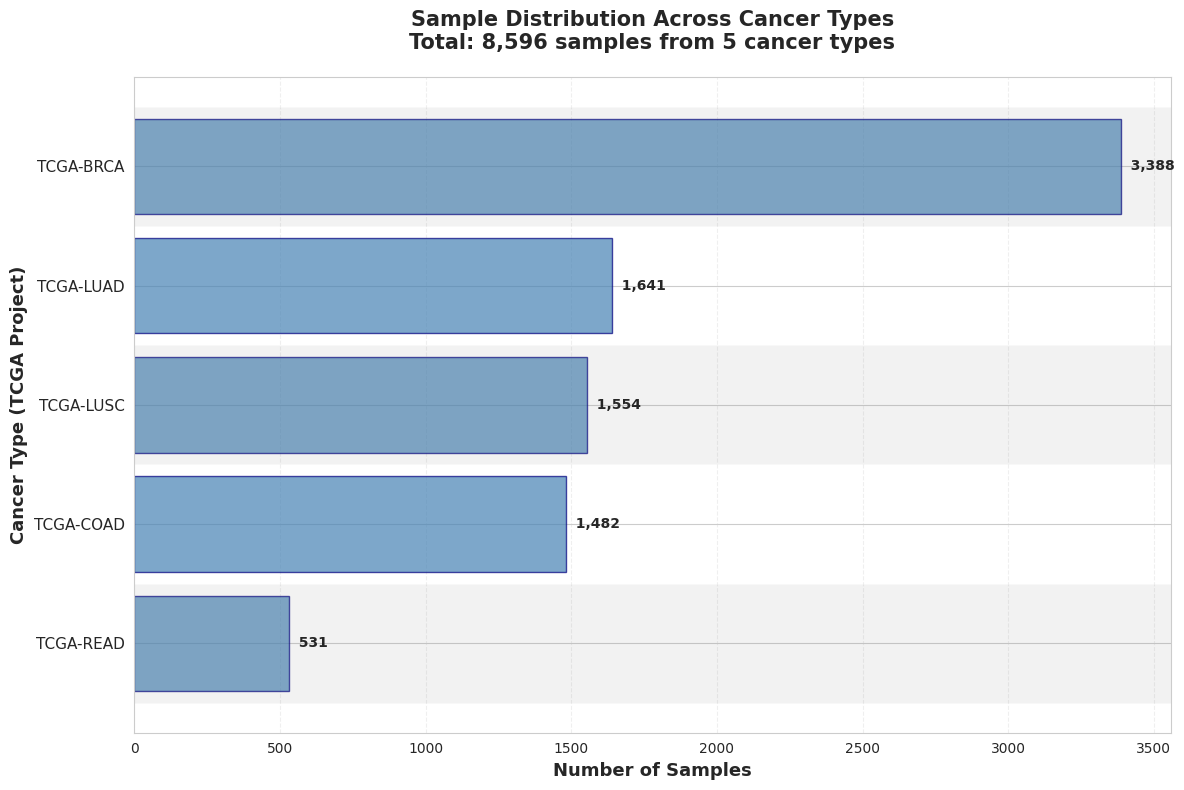


SUMMARY
Total samples: 8,596
Unique cancer types: 5

Cancer types present:
  TCGA-BRCA: 3,388 samples
  TCGA-COAD: 1,482 samples
  TCGA-LUAD: 1,641 samples
  TCGA-LUSC: 1,554 samples
  TCGA-READ: 531 samples

✓ Analysis complete!


In [5]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load data
METADATA_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/rna_features/data/metadata'
sample_path = os.path.join(METADATA_DIR, 'sample.tsv')

print("Loading sample data...")
sample_df = pd.read_csv(sample_path, sep='\t')

# Basic info
print(f"\n{'='*60}")
print("SAMPLE DATA OVERVIEW")
print(f"{'='*60}")
print(f"Total samples: {len(sample_df)}")
print(f"Number of columns: {len(sample_df.columns)}")

# Show first few rows
print(f"\n{'='*60}")
print("FIRST 5 ROWS")
print(f"{'='*60}")
print(sample_df.head())

# Check for cancer type column - now checking for dots in column names
print(f"\n{'='*60}")
print("CANCER TYPE ANALYSIS")
print(f"{'='*60}")

cancer_col = None
# Check for common column name patterns
possible_cols = ['project.project_id', 'project_id', 'disease_type', 'primary_diagnosis']
for col in possible_cols:
    if col in sample_df.columns:
        cancer_col = col
        break

if cancer_col:
    print(f"Using column: '{cancer_col}'")
    cancer_counts = sample_df[cancer_col].value_counts().sort_values(ascending=False)
    print(f"\nCancer type counts:")
    print(cancer_counts)
    print(f"\nTotal unique cancer types: {len(cancer_counts)}")
else:
    print("Could not find cancer type column")
    print(f"Available columns: {sample_df.columns.tolist()}")

# Check for sample type column
print(f"\n{'='*60}")
print("SAMPLE TYPE ANALYSIS")
print(f"{'='*60}")

sample_type_col = None
possible_type_cols = ['sample_type', 'tissue_type', 'sample.sample_type']
for col in possible_type_cols:
    if col in sample_df.columns:
        sample_type_col = col
        break

if sample_type_col:
    print(f"Using column: '{sample_type_col}'")
    sample_type_counts = sample_df[sample_type_col].value_counts()
    print(f"\nSample type counts:")
    print(sample_type_counts)
else:
    print("Could not find sample type column")
    # Look for any column with 'type' or 'sample' in name
    type_cols = [col for col in sample_df.columns if 'type' in col.lower() or 'sample' in col.lower()]
    print(f"Columns containing 'type' or 'sample': {type_cols}")

# Create visualizations
print(f"\n{'='*60}")
print("CREATING VISUALIZATIONS")
print(f"{'='*60}")

if cancer_col and cancer_col in sample_df.columns:
    cancer_counts = sample_df[cancer_col].value_counts().sort_values(ascending=True)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, max(8, len(cancer_counts) * 0.4)))
    
    # Horizontal bar chart (better for many categories)
    bars = ax.barh(range(len(cancer_counts)), cancer_counts.values, color='steelblue', edgecolor='navy', alpha=0.7)
    
    # Customize
    ax.set_yticks(range(len(cancer_counts)))
    ax.set_yticklabels(cancer_counts.index, fontsize=11)
    ax.set_xlabel('Number of Samples', fontsize=13, fontweight='bold')
    ax.set_ylabel('Cancer Type (TCGA Project)', fontsize=13, fontweight='bold')
    ax.set_title(f'Sample Distribution Across Cancer Types\nTotal: {len(sample_df):,} samples from {len(cancer_counts)} cancer types', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (idx, val) in enumerate(cancer_counts.items()):
        ax.text(val, i, f'  {val:,}', va='center', fontsize=10, fontweight='bold')
    
    # Add a subtle background color alternation for readability
    for i in range(0, len(cancer_counts), 2):
        ax.axhspan(i-0.5, i+0.5, facecolor='gray', alpha=0.1)
    
    plt.tight_layout()
    plt.savefig('tcga_cancer_types_histogram.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Histogram saved as 'tcga_cancer_types_histogram.png'")
    plt.show()
    
    # Also create a summary plot if there are sample types
    if sample_type_col and sample_type_col in sample_df.columns:
        fig2, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Top 15 cancer types
        cancer_counts_desc = sample_df[cancer_col].value_counts().head(15).sort_values(ascending=True)
        ax1 = axes[0]
        ax1.barh(range(len(cancer_counts_desc)), cancer_counts_desc.values, color='coral', edgecolor='darkred', alpha=0.7)
        ax1.set_yticks(range(len(cancer_counts_desc)))
        ax1.set_yticklabels(cancer_counts_desc.index, fontsize=10)
        ax1.set_xlabel('Number of Samples', fontsize=11)
        ax1.set_title('Top 15 Cancer Types', fontsize=13, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        
        for i, val in enumerate(cancer_counts_desc.values):
            ax1.text(val, i, f' {val:,}', va='center', fontsize=9)
        
        # Plot 2: Sample types
        sample_type_counts = sample_df[sample_type_col].value_counts()
        ax2 = axes[1]
        colors = plt.cm.Set3(range(len(sample_type_counts)))
        wedges, texts, autotexts = ax2.pie(sample_type_counts.values, 
                                             labels=sample_type_counts.index,
                                             autopct='%1.1f%%',
                                             startangle=90,
                                             colors=colors,
                                             textprops={'fontsize': 10})
        ax2.set_title('Sample Type Distribution', fontsize=13, fontweight='bold')
        
        # Make percentage text bold
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        plt.tight_layout()
        plt.savefig('tcga_summary_plots.png', dpi=300, bbox_inches='tight')
        print(f"✓ Summary plots saved as 'tcga_summary_plots.png'")
        plt.show()

else:
    print("Cannot create visualization - cancer type column not found")

# Summary statistics
print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"Total samples: {len(sample_df):,}")
if cancer_col:
    print(f"Unique cancer types: {sample_df[cancer_col].nunique()}")
    print(f"\nCancer types present:")
    for cancer_type in sorted(sample_df[cancer_col].unique()):
        count = len(sample_df[sample_df[cancer_col] == cancer_type])
        print(f"  {cancer_type}: {count:,} samples")
if sample_type_col:
    print(f"\nUnique sample types: {sample_df[sample_type_col].nunique()}")
    primary_tumor_count = len(sample_df[sample_df[sample_type_col] == 'Primary Tumor'])
    if primary_tumor_count > 0:
        print(f"Primary Tumor samples: {primary_tumor_count:,}")

print("\n✓ Analysis complete!")

In [7]:
# Define paths
METADATA_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/rna_features/data/metadata'
DOWNLOADS_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/downloads'

print("="*70)
print("LINKING DOWNLOADED FILES TO METADATA")
print("="*70)

# 1. Load metadata
print("\n1. Loading metadata...")
sample_df = pd.read_csv(os.path.join(METADATA_DIR, 'sample.tsv'), sep='\t')
print(f"   Total samples in metadata: {len(sample_df):,}")

# 2. Find downloaded files
print("\n2. Finding downloaded gene count files...")
pattern = os.path.join(DOWNLOADS_DIR, '**/*.augmented_star_gene_counts.tsv')
count_files = glob.glob(pattern, recursive=True)
print(f"   Downloaded files: {len(count_files):,}")

# 3. Extract file UUIDs
print("\n3. Extracting UUIDs from filenames...")
file_uuids = set()
for f in count_files:
    basename = os.path.basename(f)
    match = re.search(r'^([a-f0-9\-]{36})', basename)
    if match:
        file_uuids.add(match.group(1))
print(f"   Unique file UUIDs: {len(file_uuids):,}")
print(f"   Example UUIDs: {list(file_uuids)[:3]}")

# 4. Try to match with each ID column in metadata
print("\n4. Testing which metadata column contains file UUIDs...")

# Likely candidates for file IDs
id_columns = ['samples.sample_id', 'cases.case_id', 'samples.submitter_id', 'cases.submitter_id']

matched_column = None
for col in id_columns:
    if col in sample_df.columns:
        # Convert to string and check matches
        metadata_ids = set(sample_df[col].dropna().astype(str))
        matches = file_uuids.intersection(metadata_ids)
        
        print(f"   {col}: {len(matches):,} matches")
        
        if len(matches) > 100:  # If we found substantial matches
            matched_column = col
            print(f"   → Found it! Using '{col}'")
            break

# 5. If we found matches, create the histogram
if matched_column:
    print(f"\n5. Creating histogram for downloaded samples...")
    
    # Filter metadata to only downloaded samples
    downloaded_samples = sample_df[sample_df[matched_column].astype(str).isin(file_uuids)]
    
    print(f"   Downloaded samples matched: {len(downloaded_samples):,}")
    
    # Get cancer type counts
    cancer_counts = downloaded_samples['project.project_id'].value_counts().sort_values(ascending=True)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, max(8, len(cancer_counts) * 0.4)))
    
    # Horizontal bar chart
    bars = ax.barh(range(len(cancer_counts)), cancer_counts.values, 
                  color='coral', edgecolor='darkred', alpha=0.7, linewidth=1.5)
    
    # Customize
    ax.set_yticks(range(len(cancer_counts)))
    ax.set_yticklabels(cancer_counts.index, fontsize=11)
    ax.set_xlabel('Number of Downloaded Samples', fontsize=13, fontweight='bold')
    ax.set_ylabel('Cancer Type (TCGA Project)', fontsize=13, fontweight='bold')
    ax.set_title(f'Downloaded Sample Distribution Across Cancer Types\nTotal: {len(downloaded_samples):,} samples from {len(cancer_counts)} cancer types', 
                fontsize=15, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (idx, val) in enumerate(cancer_counts.items()):
        ax.text(val, i, f'  {val:,}', va='center', fontsize=10, fontweight='bold')
    
    # Add alternating background
    for i in range(0, len(cancer_counts), 2):
        ax.axhspan(i-0.5, i+0.5, facecolor='gray', alpha=0.1)
    
    plt.tight_layout()
    plt.savefig('tcga_downloaded_samples_by_cancer.png', dpi=300, bbox_inches='tight')
    print(f"\n   ✓ Histogram saved as 'tcga_downloaded_samples_by_cancer.png'")
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("DOWNLOADED SAMPLES BY CANCER TYPE")
    print("="*70)
    for cancer_type in sorted(cancer_counts.index):
        count = cancer_counts[cancer_type]
        print(f"  {cancer_type}: {count:,} samples")
    
    # Comparison with total available
    print("\n" + "="*70)
    print("DOWNLOAD COVERAGE PER CANCER TYPE")
    print("="*70)
    print(f"{'Cancer Type':<15} {'Downloaded':>10} {'Total':>10} {'Coverage':>10}")
    print("-"*50)
    
    for cancer_type in sorted(sample_df['project.project_id'].unique()):
        total = len(sample_df[sample_df['project.project_id'] == cancer_type])
        downloaded = len(downloaded_samples[downloaded_samples['project.project_id'] == cancer_type])
        pct = (downloaded / total * 100) if total > 0 else 0
        print(f"{cancer_type:<15} {downloaded:>10,} {total:>10,} {pct:>9.1f}%")
    
    # Check sample types
    if 'samples.sample_type' in downloaded_samples.columns:
        print("\n" + "="*70)
        print("DOWNLOADED SAMPLES BY SAMPLE TYPE")
        print("="*70)
        sample_types = downloaded_samples['samples.sample_type'].value_counts()
        for stype, count in sample_types.items():
            print(f"  {stype}: {count:,} samples")

else:
    print("\n   ✗ Could not find matching ID column")
    print("   Trying all columns with 'id' in the name...")
    
    # Try all columns with 'id'
    for col in sample_df.columns:
        if 'id' in col.lower():
            metadata_ids = set(sample_df[col].dropna().astype(str))
            matches = file_uuids.intersection(metadata_ids)
            if len(matches) > 0:
                print(f"   {col}: {len(matches):,} matches")

print("\n✓ Analysis complete!")

LINKING DOWNLOADED FILES TO METADATA

1. Loading metadata...
   Total samples in metadata: 8,596

2. Finding downloaded gene count files...
   Downloaded files: 3,094

3. Extracting UUIDs from filenames...
   Unique file UUIDs: 3,094
   Example UUIDs: ['784a9c63-9b40-4f6c-8147-93d0ed523867', 'c812eb06-bd41-4919-8f6d-9ade00654a4c', '550812e9-ad67-4ae6-900e-572a051208a4']

4. Testing which metadata column contains file UUIDs...
   samples.sample_id: 0 matches
   cases.case_id: 0 matches
   samples.submitter_id: 0 matches
   cases.submitter_id: 0 matches

   ✗ Could not find matching ID column
   Trying all columns with 'id' in the name...

✓ Analysis complete!


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re

# Set style
sns.set_style("whitegrid")

# Define paths
METADATA_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/rna_features/data/metadata'
DOWNLOADS_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/downloads'
MANIFEST_PATH = '/data/rbg/shared/datasets/TCGA/RNA-Seq/gdc_manifest.counts.2025-07-08.220617.txt'

print("="*70)
print("USING MANIFEST TO LINK FILES TO METADATA")
print("="*70)

# 1. Load metadata
print("\n1. Loading metadata...")
sample_df = pd.read_csv(os.path.join(METADATA_DIR, 'sample.tsv'), sep='\t')
print(f"   Total samples in metadata: {len(sample_df):,}")

# 2. Load manifest
print("\n2. Loading manifest...")
manifest_df = pd.read_csv(MANIFEST_PATH, sep='\t')
print(f"   Manifest entries: {len(manifest_df):,}")

# Show first few rows to understand structure
print("\n   First few manifest rows:")
print(manifest_df.head())

# 3. Find downloaded files
print("\n3. Finding downloaded gene count files...")
pattern = os.path.join(DOWNLOADS_DIR, '**/*.augmented_star_gene_counts.tsv')
count_files = glob.glob(pattern, recursive=True)
print(f"   Downloaded files: {len(count_files):,}")

# 4. Extract file UUIDs
print("\n4. Extracting UUIDs from filenames...")
file_uuids = set()
file_uuid_to_path = {}
for f in count_files:
    basename = os.path.basename(f)
    match = re.search(r'^([a-f0-9\-]{36})', basename)
    if match:
        uuid = match.group(1)
        file_uuids.add(uuid)
        file_uuid_to_path[uuid] = f

print(f"   Unique file UUIDs: {len(file_uuids):,}")

# 5. Match file UUIDs to manifest
print("\n5. Matching file UUIDs with manifest...")

# Extract UUID from manifest filename
manifest_df['file_uuid'] = manifest_df['filename'].str.extract(r'^([a-f0-9\-]{36})')

# Filter to downloaded files only
downloaded_manifest = manifest_df[manifest_df['file_uuid'].isin(file_uuids)]
print(f"   Matched manifest entries: {len(downloaded_manifest):,}")

# 6. The manifest has 'id' column which is the file ID
# We need to find which column links to sample metadata
print("\n6. Checking what the manifest 'id' column represents...")
print(f"   Manifest 'id' column sample: {manifest_df['id'].iloc[0]}")

# The 'id' in manifest is the file ID (same as directory name in downloads)
# We need to look at the actual directory structure
print("\n7. Checking directory structure...")
example_file = count_files[0]
print(f"   Example file path: {example_file}")

# Extract both UUIDs from path
# Path format: downloads/DIRECTORY_UUID/FILE_UUID.rna_seq.augmented_star_gene_counts.tsv
path_parts = example_file.split('/')
if len(path_parts) >= 2:
    directory_uuid = path_parts[-2]
    file_uuid = os.path.basename(example_file).split('.')[0]
    print(f"   Directory UUID: {directory_uuid}")
    print(f"   File UUID: {file_uuid}")
    
    # Check if directory UUID matches manifest 'id'
    if directory_uuid in manifest_df['id'].values:
        print(f"   ✓ Directory UUID matches manifest 'id'!")
        
        # Get all directory UUIDs
        dir_uuids = set()
        for f in count_files:
            parts = f.split('/')
            if len(parts) >= 2:
                dir_uuids.add(parts[-2])
        
        print(f"\n8. Extracting directory UUIDs from all files...")
        print(f"   Unique directory UUIDs: {len(dir_uuids):,}")
        
        # Filter manifest by directory UUIDs
        downloaded_manifest = manifest_df[manifest_df['id'].isin(dir_uuids)]
        print(f"   Matched manifest entries: {len(downloaded_manifest):,}")
        
        # Now we need to find how manifest links to sample metadata
        # The manifest might not have sample IDs directly
        # Let's check if there's a separate file that maps file IDs to sample IDs
        
        print("\n9. Looking for file-to-sample mapping...")
        
        # Check if there are JSON metadata files
        json_pattern = os.path.join(DOWNLOADS_DIR, '**/*.json')
        json_files = glob.glob(json_pattern, recursive=True)
        
        if len(json_files) > 0:
            print(f"   Found {len(json_files)} JSON metadata files")
            print("   Checking first JSON file...")
            
            import json
            with open(json_files[0], 'r') as f:
                metadata = json.load(f)
            
            print(f"   JSON keys: {metadata.keys() if isinstance(metadata, dict) else 'Not a dict'}")
            
            # Look for sample/aliquot/case IDs in JSON
            if isinstance(metadata, dict):
                for key in ['associated_entities', 'cases', 'samples', 'aliquots']:
                    if key in metadata:
                        print(f"   Found '{key}' in JSON metadata")
                        print(f"   Sample: {metadata[key]}")
        else:
            print("   No JSON metadata files found")
            print("\n   Alternative: Extracting cancer types from filenames in manifest")
            
            # GDC filenames sometimes embed sample IDs
            # Format: TCGA-XX-YYYY-...
            if 'filename' in manifest_df.columns:
                print("\n10. Trying to extract TCGA sample IDs from filenames...")
                
                # Look for TCGA-XX-XXXX pattern in manifest
                tcga_pattern = r'(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})'
                
                # Check if filenames contain TCGA IDs
                sample_filenames = manifest_df['filename'].head(10)
                print(f"\n   Sample filenames from manifest:")
                for fn in sample_filenames:
                    print(f"   - {fn}")

print("\n✓ Diagnosis complete - awaiting next steps...")

USING MANIFEST TO LINK FILES TO METADATA

1. Loading metadata...
   Total samples in metadata: 8,596

2. Loading manifest...
   Manifest entries: 3,094

   First few manifest rows:
                                     id  \
0  3396edba-0d2a-4485-ad0a-5114b38c1abe   
1  d2e2915c-125e-45c6-b7f3-6a815b3d2859   
2  fb32f0b1-4fb7-43d5-8091-dc13a1f6d9e8   
3  de5e449b-bc57-4836-89e4-73a3ba24abdf   
4  a58e2ae3-a236-4209-8292-70465216cb85   

                                            filename  \
0  2e64abe2-6024-4d28-9e09-560ce2a9fd15.rna_seq.a...   
1  96a45a70-d4b5-4090-b603-73b7379679d6.rna_seq.a...   
2  1d468785-141d-40ca-acb1-d6d85a8c9d7b.rna_seq.a...   
3  748e4eaa-2b96-4dce-a903-c7df733d7f50.rna_seq.a...   
4  e614fbb4-7574-4704-9525-c0aea4c10fc6.rna_seq.a...   

                                md5     size     state  
0  25a162e0b1fa52e5a06881efcb56784e  4231290  released  
1  e46cabde61f942e44cea63c347f1e5f2  4247897  released  
2  014bebf8b00089c3524d39200bce491c  4246171  releas

In [9]:
sample_df.head(10)

,project.project_id,cases.case_id,cases.submitter_id,samples.biospecimen_anatomic_site,samples.biospecimen_laterality,samples.catalog_reference,samples.composition,samples.current_weight,samples.days_to_collection,samples.days_to_sample_procurement,...,samples.specimen_type,samples.state,samples.submitter_id,samples.time_between_clamping_and_freezing,samples.time_between_excision_and_freezing,samples.tissue_collection_type,samples.tissue_type,samples.tumor_code,samples.tumor_code_id,samples.tumor_descriptor
0,TCGA-READ,8ad1c98b-5395-477e-87a8-19dff3a59c26,TCGA-AG-A02N,'--,'--,'--,'--,'--,'--,0,...,Solid Tissue,released,TCGA-AG-A02N-01Z,'--,'--,'--,Tumor,'--,'--,Primary
1,TCGA-READ,8ad1c98b-5395-477e-87a8-19dff3a59c26,TCGA-AG-A02N,'--,'--,'--,Not Reported,'--,1975,'--,...,Solid Tissue,released,TCGA-AG-A02N-11A,'--,'--,'--,Normal,'--,'--,Not Applicable
2,TCGA-READ,8ad1c98b-5395-477e-87a8-19dff3a59c26,TCGA-AG-A02N,'--,'--,'--,Not Reported,'--,1827,'--,...,Solid Tissue,released,TCGA-AG-A02N-01A,'--,'--,'--,Tumor,'--,'--,Primary
3,TCGA-BRCA,15ff4b02-bb69-4d24-8a07-b82f428e428d,TCGA-A7-A3IZ,'--,'--,'--,Not Reported,'--,86,'--,...,Unknown,released,TCGA-A7-A3IZ-01A,'--,'--,'--,Tumor,'--,'--,Primary
4,TCGA-BRCA,15ff4b02-bb69-4d24-8a07-b82f428e428d,TCGA-A7-A3IZ,'--,'--,'--,Not Reported,'--,86,'--,...,Peripheral Blood NOS,released,TCGA-A7-A3IZ-10A,'--,'--,'--,Normal,'--,'--,Not Applicable
5,TCGA-BRCA,15ff4b02-bb69-4d24-8a07-b82f428e428d,TCGA-A7-A3IZ,'--,'--,'--,'--,'--,'--,0,...,Solid Tissue,released,TCGA-A7-A3IZ-01Z,'--,'--,'--,Tumor,'--,'--,Primary
6,TCGA-LUAD,9f81c602-8afa-4588-b0b6-6e5a1a128d5a,TCGA-05-4396,'--,'--,'--,'--,'--,'--,0,...,Solid Tissue,released,TCGA-05-4396-01Z,'--,'--,'--,Tumor,'--,'--,Primary
7,TCGA-LUAD,9f81c602-8afa-4588-b0b6-6e5a1a128d5a,TCGA-05-4396,'--,'--,'--,Not Reported,'--,'--,'--,...,Peripheral Blood NOS,released,TCGA-05-4396-10A,'--,'--,'--,Normal,'--,'--,Not Applicable
8,TCGA-LUAD,9f81c602-8afa-4588-b0b6-6e5a1a128d5a,TCGA-05-4396,'--,'--,'--,Not Reported,'--,'--,'--,...,Solid Tissue,released,TCGA-05-4396-01A,'--,'--,'--,Tumor,'--,'--,Primary
9,TCGA-READ,856a490c-c6da-48fe-88b5-9fde0f481365,TCGA-AG-3728,'--,'--,'--,Not Reported,'--,'--,'--,...,Solid Tissue,released,TCGA-AG-3728-01A,'--,'--,'--,Tumor,'--,'--,Primary


In [11]:
sample_df.loc[sample_df["cases.case_id"] == "ac271c9e-4219-4880-ad89-0df6d5df0bb4"]

,project.project_id,cases.case_id,cases.submitter_id,samples.biospecimen_anatomic_site,samples.biospecimen_laterality,samples.catalog_reference,samples.composition,samples.current_weight,samples.days_to_collection,samples.days_to_sample_procurement,...,samples.specimen_type,samples.state,samples.submitter_id,samples.time_between_clamping_and_freezing,samples.time_between_excision_and_freezing,samples.tissue_collection_type,samples.tissue_type,samples.tumor_code,samples.tumor_code_id,samples.tumor_descriptor


In [12]:
import pandas as pd

# Load the file
aliquot_path = '/data/rbg/shared/datasets/TCGA/RNA-Seq/rna_features/data/metadata/aliquot.tsv'
aliquot_df = pd.read_csv(aliquot_path, sep='\t')

# Basic info
print(f"Shape: {aliquot_df.shape}")
print(f"Rows: {len(aliquot_df):,}")
print(f"Columns: {len(aliquot_df.columns)}")

# Show all column names
print("\nColumn names:")
for i, col in enumerate(aliquot_df.columns, 1):
    print(f"{i:2d}. {col}")

# Show first few rows
print("\nFirst 5 rows:")
print(aliquot_df.head())

# Show data types
print("\nData types:")
print(aliquot_df.dtypes)

# Look for columns with 'id', 'file', or 'sample'
print("\nColumns containing 'id':")
id_cols = [col for col in aliquot_df.columns if 'id' in col.lower()]
print(id_cols)

print("\nColumns containing 'file':")
file_cols = [col for col in aliquot_df.columns if 'file' in col.lower()]
print(file_cols)

print("\nColumns containing 'sample':")
sample_cols = [col for col in aliquot_df.columns if 'sample' in col.lower()]
print(sample_cols)

# Show example values from key columns
if 'aliquots.aliquot_id' in aliquot_df.columns:
    print("\nExample aliquot IDs:")
    print(aliquot_df['aliquots.aliquot_id'].head(3))

if 'samples.sample_id' in aliquot_df.columns:
    print("\nExample sample IDs:")
    print(aliquot_df['samples.sample_id'].head(3))

Shape: (44662, 27)
Rows: 44,662
Columns: 27

Column names:
 1. project.project_id
 2. cases.case_id
 3. cases.submitter_id
 4. samples.sample_id
 5. samples.submitter_id
 6. portions.portion_id
 7. portions.submitter_id
 8. analytes.analyte_id
 9. analytes.submitter_id
10. aliquots.aliquot_id
11. aliquots.aliquot_quantity
12. aliquots.aliquot_volume
13. aliquots.amount
14. aliquots.analyte_type
15. aliquots.analyte_type_id
16. aliquots.concentration
17. aliquots.no_matched_normal_low_pass_wgs
18. aliquots.no_matched_normal_targeted_sequencing
19. aliquots.no_matched_normal_wgs
20. aliquots.no_matched_normal_wxs
21. aliquots.selected_normal_low_pass_wgs
22. aliquots.selected_normal_targeted_sequencing
23. aliquots.selected_normal_wgs
24. aliquots.selected_normal_wxs
25. aliquots.source_center
26. aliquots.state
27. aliquots.submitter_id

First 5 rows:
  project.project_id                         cases.case_id cases.submitter_id  \
0          TCGA-READ  8ad1c98b-5395-477e-87a8-19dff3a59c

In [13]:
# Set style
sns.set_style("whitegrid")

# Define paths
METADATA_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/rna_features/data/metadata'
DOWNLOADS_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/downloads'
MANIFEST_PATH = '/data/rbg/shared/datasets/TCGA/RNA-Seq/gdc_manifest.counts.2025-07-08.220617.txt'

print("="*70)
print("LINKING FILES TO CANCER TYPES VIA ALIQUOT")
print("="*70)

# 1. Load aliquot data
print("\n1. Loading aliquot.tsv...")
aliquot_df = pd.read_csv(os.path.join(METADATA_DIR, 'aliquot.tsv'), sep='\t')
print(f"   Aliquot entries: {len(aliquot_df):,}")

# 2. Find downloaded files
print("\n2. Finding downloaded gene count files...")
pattern = os.path.join(DOWNLOADS_DIR, '**/*.augmented_star_gene_counts.tsv')
count_files = glob.glob(pattern, recursive=True)
print(f"   Downloaded files: {len(count_files):,}")

# 3. Extract file UUIDs (these should be aliquot IDs)
print("\n3. Extracting UUIDs from filenames...")
file_uuids = set()
for f in count_files:
    basename = os.path.basename(f)
    match = re.search(r'^([a-f0-9\-]{36})', basename)
    if match:
        file_uuids.add(match.group(1))

print(f"   Unique file UUIDs: {len(file_uuids):,}")
print(f"   Example file UUID: {list(file_uuids)[0]}")

# 4. Check if file UUIDs match aliquot IDs
print("\n4. Matching file UUIDs to aliquot IDs...")
if 'aliquots.aliquot_id' in aliquot_df.columns:
    aliquot_ids = set(aliquot_df['aliquots.aliquot_id'].dropna().astype(str))
    matches = file_uuids.intersection(aliquot_ids)
    
    print(f"   Matches found: {len(matches):,}")
    
    if len(matches) > 100:
        print("   ✓ File UUIDs match aliquot IDs!")
        
        # Filter aliquot data to downloaded files
        downloaded_aliquots = aliquot_df[aliquot_df['aliquots.aliquot_id'].isin(file_uuids)]
        print(f"   Downloaded aliquots: {len(downloaded_aliquots):,}")
        
        # Get cancer type distribution
        print("\n5. Analyzing cancer types...")
        cancer_counts = downloaded_aliquots['project.project_id'].value_counts().sort_values(ascending=True)
        
        print(f"   Unique cancer types: {len(cancer_counts)}")
        
        # Create histogram
        print("\n6. Creating histogram...")
        
        fig, ax = plt.subplots(figsize=(12, max(8, len(cancer_counts) * 0.4)))
        
        bars = ax.barh(range(len(cancer_counts)), cancer_counts.values, 
                      color='coral', edgecolor='darkred', alpha=0.7, linewidth=1.5)
        
        ax.set_yticks(range(len(cancer_counts)))
        ax.set_yticklabels(cancer_counts.index, fontsize=11)
        ax.set_xlabel('Number of Downloaded Samples', fontsize=13, fontweight='bold')
        ax.set_ylabel('Cancer Type (TCGA Project)', fontsize=13, fontweight='bold')
        ax.set_title(f'Downloaded Sample Distribution Across Cancer Types\nTotal: {len(downloaded_aliquots):,} samples from {len(cancer_counts)} cancer types', 
                    fontsize=15, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels
        for i, (idx, val) in enumerate(cancer_counts.items()):
            ax.text(val, i, f'  {val:,}', va='center', fontsize=10, fontweight='bold')
        
        # Alternating background
        for i in range(0, len(cancer_counts), 2):
            ax.axhspan(i-0.5, i+0.5, facecolor='gray', alpha=0.1)
        
        plt.tight_layout()
        plt.savefig('tcga_downloaded_samples_by_cancer.png', dpi=300, bbox_inches='tight')
        print(f"   ✓ Histogram saved as 'tcga_downloaded_samples_by_cancer.png'")
        plt.show()
        
        # Print detailed summary
        print("\n" + "="*70)
        print("DOWNLOADED SAMPLES BY CANCER TYPE")
        print("="*70)
        for cancer_type in sorted(cancer_counts.index):
            count = cancer_counts[cancer_type]
            print(f"  {cancer_type}: {count:,} samples")
        
        # Get unique samples (in case multiple aliquots per sample)
        unique_samples = downloaded_aliquots['samples.sample_id'].nunique()
        unique_cases = downloaded_aliquots['cases.case_id'].nunique()
        
        print("\n" + "="*70)
        print("SUMMARY STATISTICS")
        print("="*70)
        print(f"  Total aliquots (files): {len(downloaded_aliquots):,}")
        print(f"  Unique samples: {unique_samples:,}")
        print(f"  Unique cases (patients): {unique_cases:,}")
        print(f"  Cancer types: {len(cancer_counts)}")
        
        # Compare with COMPASS requirements
        print("\n" + "="*70)
        print("COMPARISON WITH COMPASS")
        print("="*70)
        print(f"  COMPASS used: 10,184 patients")
        print(f"  You have: {unique_cases:,} patients ({unique_cases/10184*100:.1f}% of COMPASS)")
        
        # Check if you have the 7 key cancer types COMPASS tested
        compass_cancers = ['TCGA-BLCA', 'TCGA-GBM', 'TCGA-KIRC', 'TCGA-LUAD', 
                          'TCGA-LUSC', 'TCGA-SKCM', 'TCGA-STAD']
        
        print("\n  Key COMPASS cancer types coverage:")
        for cancer in compass_cancers:
            if cancer in cancer_counts.index:
                print(f"    ✓ {cancer}: {cancer_counts[cancer]:,} samples")
            else:
                print(f"    ✗ {cancer}: Not in your download")
    
    else:
        print("   ✗ Not enough matches - file UUIDs may not be aliquot IDs")
        print(f"   Example file UUID: {list(file_uuids)[0]}")
        print(f"   Example aliquot ID: {aliquot_df['aliquots.aliquot_id'].iloc[0]}")

else:
    print("   ✗ 'aliquots.aliquot_id' column not found")

print("\n✓ Complete!")

LINKING FILES TO CANCER TYPES VIA ALIQUOT

1. Loading aliquot.tsv...
   Aliquot entries: 44,662

2. Finding downloaded gene count files...
   Downloaded files: 3,094

3. Extracting UUIDs from filenames...
   Unique file UUIDs: 3,094
   Example file UUID: 784a9c63-9b40-4f6c-8147-93d0ed523867

4. Matching file UUIDs to aliquot IDs...
   Matches found: 0
   ✗ Not enough matches - file UUIDs may not be aliquot IDs
   Example file UUID: 784a9c63-9b40-4f6c-8147-93d0ed523867
   Example aliquot ID: 348ae381-9a11-41ae-98b8-b86fa1a17644

✓ Complete!
